<a href="https://colab.research.google.com/github/Tashu1208/DL-Project/blob/main/MNIST_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
#LOAd the data
import torch
import torchvision
from torchvision.transforms import ToTensor,Normalize,Compose
from torchvision.datasets import MNIST

In [4]:
mnist = MNIST(root='data',
              train=True,
              download = True,
              transform = Compose([ToTensor(),Normalize(mean=(0.5,),std=(0.5,))]))

In [5]:
img,label =mnist[0]
print("label: ",label)
print(img[:,10:15,10:15])
torch.min(img), torch.max(img)

label:  5
tensor([[[-0.9922,  0.2078,  0.9843, -0.2941, -1.0000],
         [-1.0000,  0.0902,  0.9843,  0.4902, -0.9843],
         [-1.0000, -0.9137,  0.4902,  0.9843, -0.4510],
         [-1.0000, -1.0000, -0.7255,  0.8902,  0.7647],
         [-1.0000, -1.0000, -1.0000, -0.3647,  0.8824]]])


(tensor(-1.), tensor(1.))

In [6]:
def denorm(x):
  out= (x+1)/2
  return out.clamp(0,1)

Label:  5


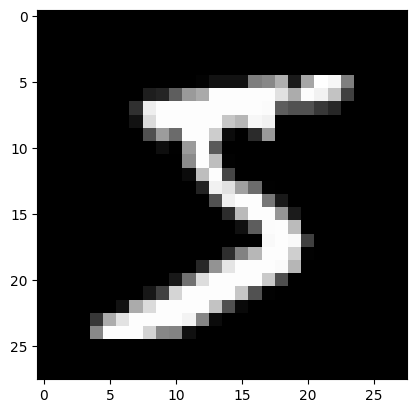

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

img_norm = denorm(img)
plt.imshow(img_norm[0],cmap='gray')
print('Label: ', label)

Label: 1


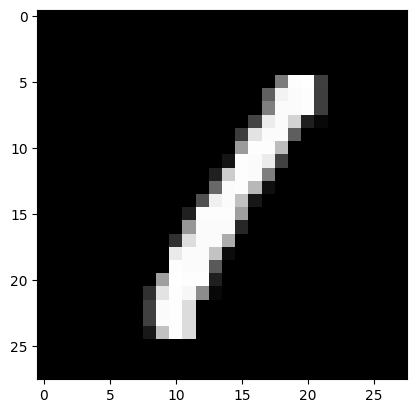

In [8]:
img,label =mnist[3]
img_norm= denorm(img)
plt.imshow(img_norm[0], cmap='gray')
print('Label:', label)

In [9]:
from torch.utils.data import DataLoader

batch_size = 100
data_loader = DataLoader(mnist,batch_size,shuffle=True)

first batch
torch.Size([100, 1, 28, 28])
tensor([5, 4, 0, 7, 7, 7, 3, 5, 4, 2, 3, 1, 4, 3, 2, 9, 4, 9, 8, 6, 0, 8, 9, 2,
        7, 5, 3, 7, 6, 5, 1, 2, 3, 9, 3, 4, 5, 8, 8, 0, 6, 1, 7, 2, 4, 6, 7, 1,
        8, 8, 6, 1, 9, 3, 2, 6, 2, 4, 2, 1, 4, 6, 2, 8, 0, 9, 4, 5, 8, 3, 9, 1,
        2, 3, 0, 3, 5, 7, 3, 4, 6, 3, 6, 3, 3, 2, 7, 0, 5, 8, 5, 9, 7, 4, 6, 9,
        2, 3, 5, 6])


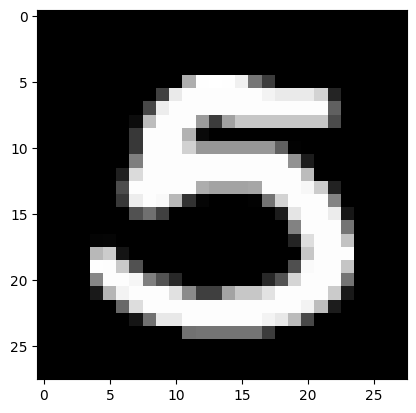

In [10]:
for img_batch,label_batch in data_loader:
  print('first batch')
  print(img_batch.shape)
  plt.imshow(img_batch[0][0],cmap='gray')
  print(label_batch)
  break

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:
device

device(type='cuda')

In [13]:
#Discriminator network
image_size = 784
hidden_size = 256

In [14]:
import torch.nn as nn
D = nn.Sequential(
    nn.Linear(image_size,hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size,hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size,1),
    nn.Sigmoid()
)

In [15]:
D.to(device)

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.2)
  (4): Linear(in_features=256, out_features=1, bias=True)
  (5): Sigmoid()
)

In [16]:
#Generator
latent_size = 64

In [17]:
G = nn.Sequential(
    nn.Linear(latent_size,hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size,hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size,image_size),
    nn.Tanh()
)

In [18]:
G

Sequential(
  (0): Linear(in_features=64, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=784, bias=True)
  (5): Tanh()
)

In [19]:
y= G(torch.randn(2,latent_size))
gen_img= denorm(y.reshape((-1,28,28)).detach())

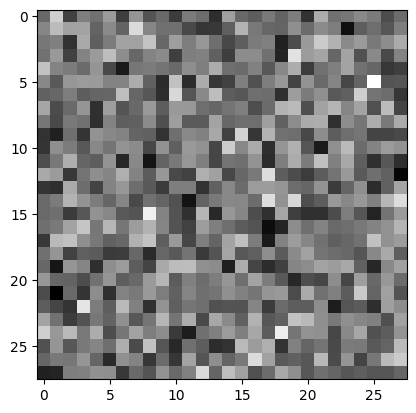

In [20]:
plt.imshow(gen_img[0], cmap='gray')

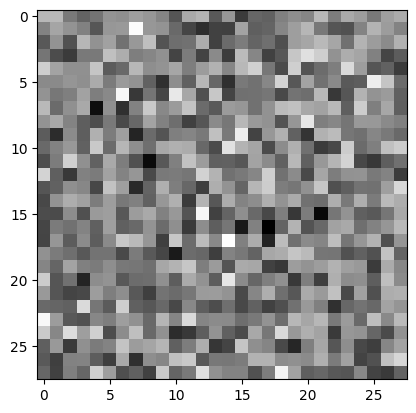

In [21]:
plt.imshow(gen_img[1], cmap='gray')

In [22]:
G.to(device)

Sequential(
  (0): Linear(in_features=64, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=784, bias=True)
  (5): Tanh()
)

#Discriminator Training

In [23]:
#Binary Classification so we can use binary cross entropy
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(),lr=0.0002)
g_optimizer = torch.optim.Adam(G.parameters(),lr=0.0002)

In [24]:
#Helper functionss
def reset_grad():
  d_optimizer.zero_grad()
  g_optimizer.zero_grad()

def train_discriminator(images):
  real_labels = torch.ones(batch_size,1).to(device)
  fake_labels = torch.zeros(batch_size,1).to(device)

  outputs= D(images)
  d_loss_real = criterion(outputs,real_labels)
  real_score = outputs

  z = torch.randn(batch_size,latent_size).to(device)
  fake_images = G(z)
  outputs = D(fake_images)
  d_loss_fake = criterion(outputs,fake_labels)
  fake_score = outputs

  d_loss = d_loss_real + d_loss_fake

  reset_grad()
  d_loss.backward()
  d_optimizer.step()

  return d_loss,real_score,fake_score

#Generator Training

In [25]:
def train_generator():
  z = torch.randn(batch_size,latent_size).to(device)
  fake_images = G(z)
  labels = torch.ones(batch_size,1).to(device)
  g_loss = criterion(D(fake_images),labels)

  reset_grad()
  g_loss.backward()
  g_optimizer.step()
  return g_loss, fake_images

#Training

In [26]:
import os
sample_dir = 'samples'
if not os.path.exists(sample_dir):
  os.makedirs(sample_dir)

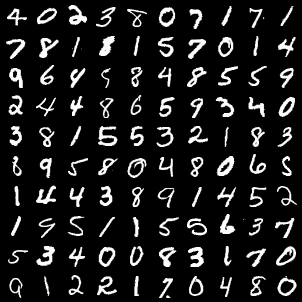

In [27]:
from IPython.display import Image
from torchvision.utils import save_image
for images, _ in data_loader:
    images = images.reshape(images.size(0), 1, 28, 28)
    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow=10)
    break

Image(os.path.join(sample_dir, 'real_images.png'))

Saving fake_images-0000.png


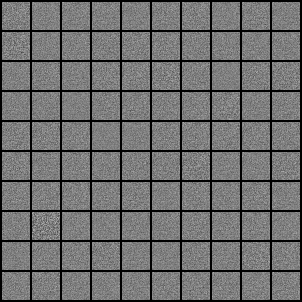

In [28]:
sample_vectors = torch.randn(batch_size, latent_size).to(device)

def save_fake_images(index):
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)

save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000.png'))


In [29]:
%%time

num_epochs = 50
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)

        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()

        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()))

    # Sample and save images
    save_fake_images(epoch+1)

Epoch [0/50], Step [200/600], d_loss: 0.0473, g_loss: 4.2078, D(x): 1.00, D(G(z)): 0.04
Epoch [0/50], Step [400/600], d_loss: 0.1051, g_loss: 5.2537, D(x): 0.97, D(G(z)): 0.05
Epoch [0/50], Step [600/600], d_loss: 0.1453, g_loss: 5.1416, D(x): 0.92, D(G(z)): 0.04
Saving fake_images-0001.png
Epoch [1/50], Step [200/600], d_loss: 0.0494, g_loss: 5.2392, D(x): 0.99, D(G(z)): 0.03
Epoch [1/50], Step [400/600], d_loss: 0.2351, g_loss: 4.4442, D(x): 0.88, D(G(z)): 0.03
Epoch [1/50], Step [600/600], d_loss: 0.6034, g_loss: 5.4864, D(x): 0.87, D(G(z)): 0.19
Saving fake_images-0002.png
Epoch [2/50], Step [200/600], d_loss: 0.4765, g_loss: 3.0194, D(x): 0.84, D(G(z)): 0.12
Epoch [2/50], Step [400/600], d_loss: 0.4692, g_loss: 3.9738, D(x): 0.87, D(G(z)): 0.18
Epoch [2/50], Step [600/600], d_loss: 0.2927, g_loss: 4.4637, D(x): 0.96, D(G(z)): 0.19
Saving fake_images-0003.png
Epoch [3/50], Step [200/600], d_loss: 0.7386, g_loss: 3.4080, D(x): 0.81, D(G(z)): 0.25
Epoch [3/50], Step [400/600], d_loss

In [30]:
#Save the model
torch.save(G.state_dict(),'G.ckpt')
torch.save(D.state_dict(),'D.ckpt')

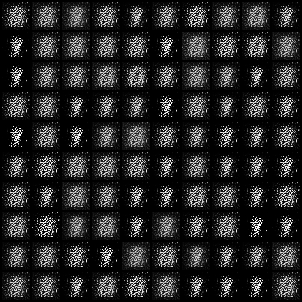

In [31]:
Image('/content/samples/fake_images-0006.png')

In [33]:
import cv2
import os
from IPython.display import FileLink

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'fake_images' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 8, (302,302))
[out.write(cv2.imread(fname)) for fname in files]
out.release()
FileLink('gans_training.avi')

/content/gans_training.avi

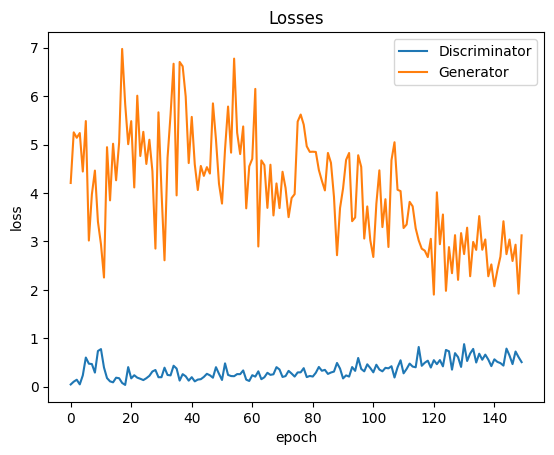

In [34]:
# Losses vs epoch
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

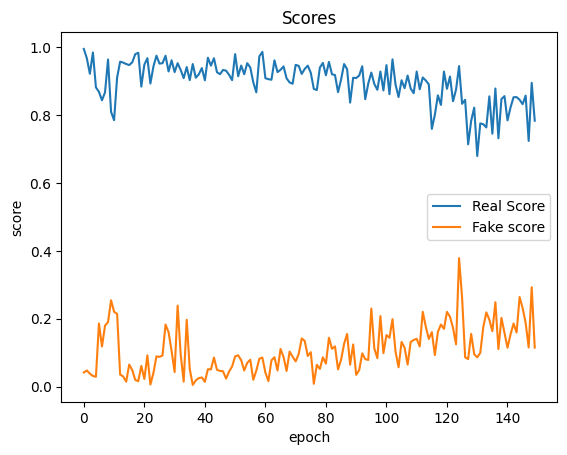

In [35]:
#scores vs epoch
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');

In [36]:
!pip install jovian --upgrade -q
import jovian
jovian.commit

<function jovian.utils.commit.commit(message=None, files=[], outputs=[], environment=None, privacy='auto', filename=None, project=None, new_project=None, git_commit=False, git_message='auto', require_write_access=False, **kwargs)>